In [65]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       plot_feature_dependence, plot_feature_dependencies
from util import calc_ground_truth_constraints, constraint_matrix_to_rules, RuleClassifier
from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
shap.initjs()
%matplotlib inline

# Make Task

In [63]:
feature_names = np.array(['x1', 'x2'])
feature_precisions = [1, 1]

In [14]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=0)
X *= 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
lm = LogisticRegression()
lm.fit(X_train, y_train)
clf_a = lm

clf_b = LogisticRegression()
X2 = X.copy()
X2[:, 0] = 0
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.5, random_state=0)
clf_b.fit(X2_train, y2_train)

X_explain = X_test
y_explain = y_test

with open('task.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions), f)

In [64]:
with open('task.pickle', 'rb') as f:
    clf_a, clf_b, X_explain, y_explain, feature_names, feature_precisions = pickle.load(f)

In [68]:
print(classification_report(clf_a.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        66
           1       0.92      0.85      0.88        84

    accuracy                           0.87       150
   macro avg       0.87      0.88      0.87       150
weighted avg       0.88      0.87      0.87       150



In [69]:
print(classification_report(clf_b.predict(X2_test), y2_test))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82        63
           1       0.91      0.80      0.85        87

    accuracy                           0.84       150
   macro avg       0.84      0.85      0.84       150
weighted avg       0.85      0.84      0.84       150



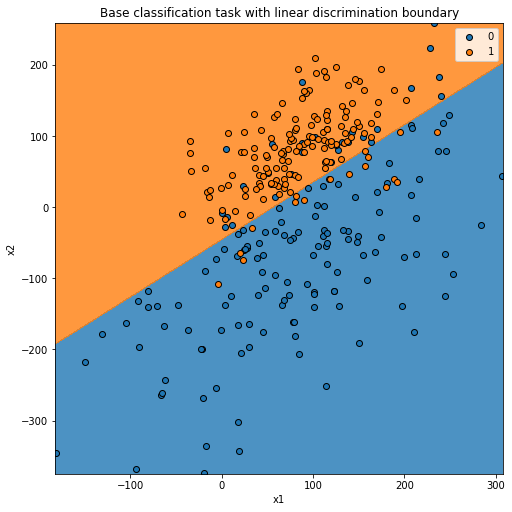

In [15]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=clf_a.predict, class_names=clf_a.classes_,
                       fig=fig, ax=ax)

In [16]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

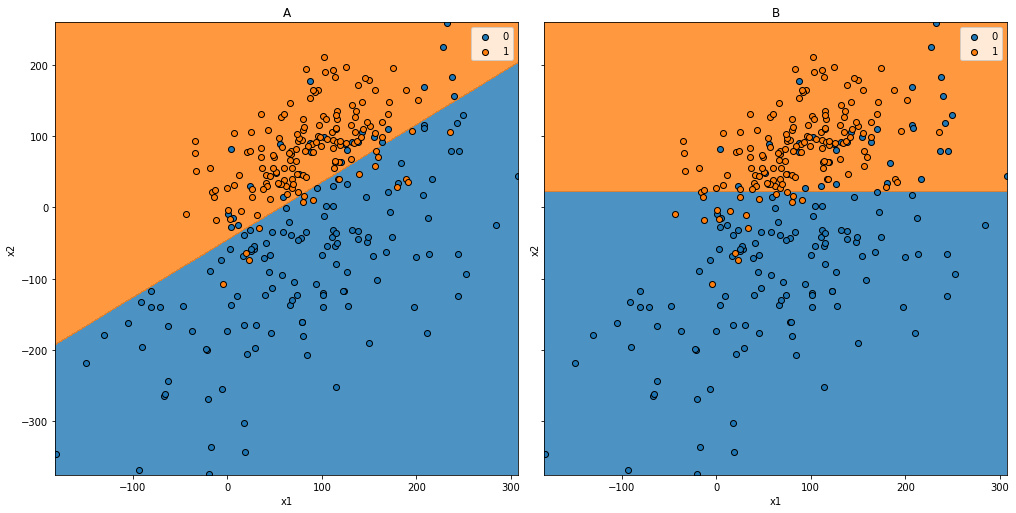

In [17]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')
plt.savefig('b-ignores-feature-decision-boundaries-indiv.pdf')

In [18]:
clf_a.coef_, clf_a.intercept_

(array([[-0.02339328,  0.02894723]]), array([1.31734334]))

In [19]:
clf_b.coef_, clf_b.intercept_

(array([[0.        , 0.01712693]]), array([-0.37894697]))

In [20]:
x2_lim = -clf_b.intercept_[0]/clf_b.coef_[0][1]
x2_lim

22.125795775193605

In [21]:
x1_where_x2_crosses = (-clf_a.intercept_[0] - clf_a.coef_[0][1]*x2_lim)/clf_a.coef_[0][0]
x1_where_x2_crosses

83.69171686589276

In [22]:
intercept = -clf_a.intercept_[0]/clf_a.coef_[0][1]
intercept

-45.508443860900975

In [23]:
slope = -clf_a.coef_[0][0]/clf_a.coef_[0][1]
slope

0.8081354065716131

A logistic regression model discriminates at 0, therefore the decision boundary is given by the function $\beta_0 + \beta_1 x_1 + \beta_2 x_2 = 0$

The decision boundary for A can be expressed as a function of $x_1$: $f(x_1) = -\frac{\beta_0}{\beta_2} - \frac{\beta_1}{\beta_2}x_1$

Since for B it is true that $\beta_1=0$, then the decision boundary is given by $x_2^*=\frac{-\beta_0}{\beta_2}$

- $x_1 > 80.67 \land 21.35 < x2 \leq -38.16 + 0.74 x_1$
- $x_1 \leq 80.67 \land -38.16 + 0.74 x_1 < x2 \leq 21.35$

In [24]:
rules_01 = [f'x1 > {x1_where_x2_crosses} and {x2_lim} < x2 <= {intercept} + {slope} * x1']
rules_01

['x1 > 83.69171686589276 and 22.125795775193605 < x2 <= -45.508443860900975 + 0.8081354065716131 * x1']

In [25]:
rules_10 = [f'x1 <= {x1_where_x2_crosses} and {intercept} + {slope} * x1 < x2 <= {x2_lim}']
rules_10

['x1 <= 83.69171686589276 and -45.508443860900975 + 0.8081354065716131 * x1 < x2 <= 22.125795775193605']

In [26]:
def calc_01_x2_boundaries(x1):
    if x1 <= x1_where_x2_crosses:
        raise Exception('invalid x1 value')
    lower_boundary = x2_lim
    upper_boundary = intercept + slope * x1
    return lower_boundary, upper_boundary

In [27]:
def calc_01_x1_boundaries(x2):
    if x2 <= x2_lim:
        raise Exception('invalid x2 value')
    lower_boundary = (x2 - intercept)/slope
    upper_boundary = np.nan
    return lower_boundary, upper_boundary

In [28]:
def calc_10_x2_boundaries(x1):
    if x1 > x1_where_x2_crosses:
        raise Exception('invalid x1 value')
    lower_boundary = intercept + slope * x1
    upper_boundary = x2_lim
    return lower_boundary, upper_boundary

In [29]:
def calc_10_x1_boundaries(x2):
    if x2 > x2_lim:
        raise Exception('invalid x2 value')
    lower_boundary = np.nan
    upper_boundary = (x2 - intercept)/slope
    return lower_boundary, upper_boundary

In [30]:
rclf = RuleClassifier(feature_names, rules_01)

In [31]:
calc_01_x2_boundaries(200)

(22.125795775193605, 116.11863745342166)

In [32]:
X_test = [[200, 110]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [33]:
X_test = [[200, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [34]:
calc_01_x1_boundaries(109)

(191.19128131803885, nan)

In [35]:
X_test = [[199, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [36]:
X_test = [[200, 109]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(0, 1)'], dtype='<U6'))

In [37]:
rclf = RuleClassifier(feature_names, rules_10)

In [38]:
calc_10_x2_boundaries(0)

(-45.508443860900975, 22.125795775193605)

In [39]:
X_test = [[0, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [40]:
X_test = [[0, -39]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [41]:
calc_10_x1_boundaries(-38)

(nan, 9.291071520742252)

In [42]:
X_test = [[0, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

In [43]:
X_test = [[1, -38]]
rclf.predict(X_test), comparer.class_names[comparer.predict_mclass_diff(X_test)]

(array([ True]), array(['(1, 0)'], dtype='<U6'))

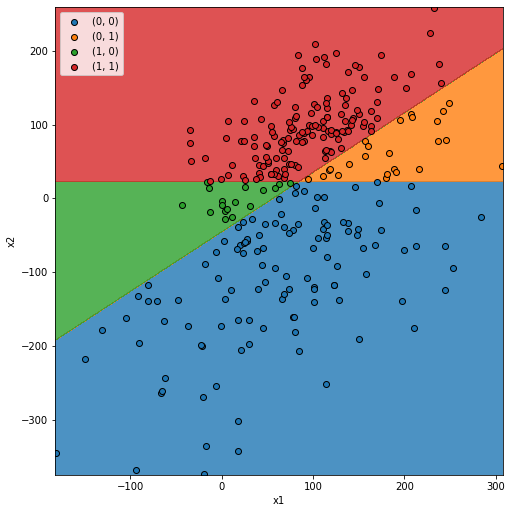

In [44]:
comparer.plot_decision_boundaries(X)
plt.savefig('b-ignores-feature-decision-boundaries-diffclf.pdf')

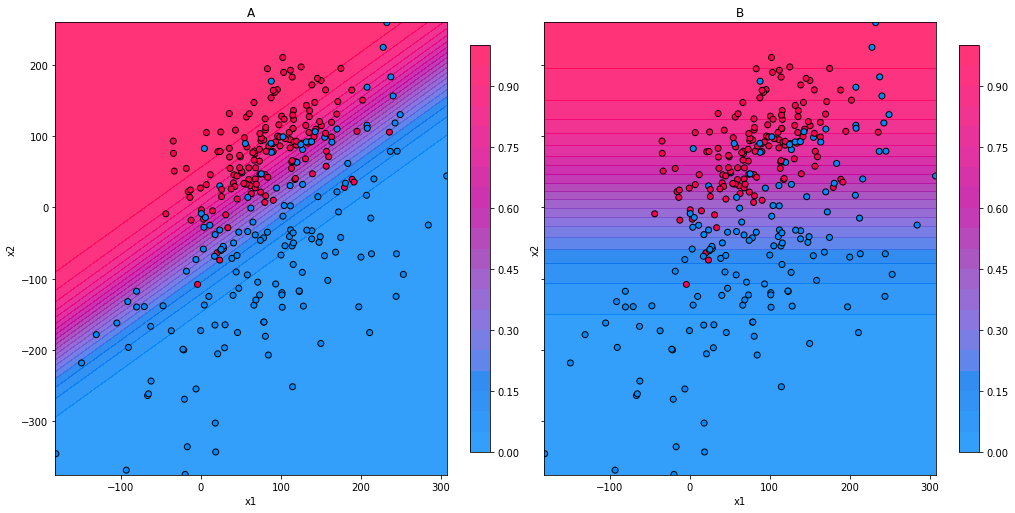

In [45]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='proba')
plt.savefig('b-ignores-feature-decision-boundaries-indiv-proba.pdf')

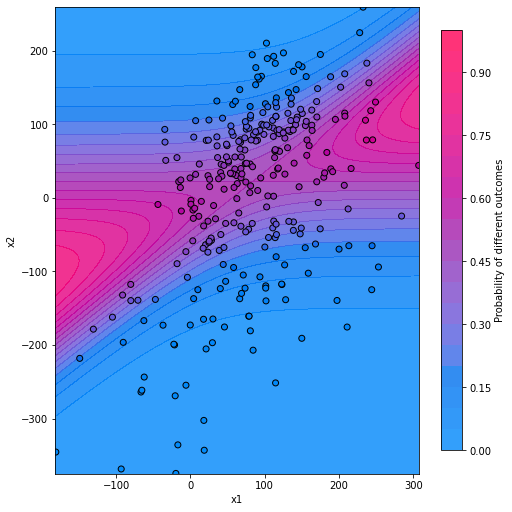

In [46]:
comparer.plot_decision_boundaries(X, kind='proba', type='bin-diffclf')

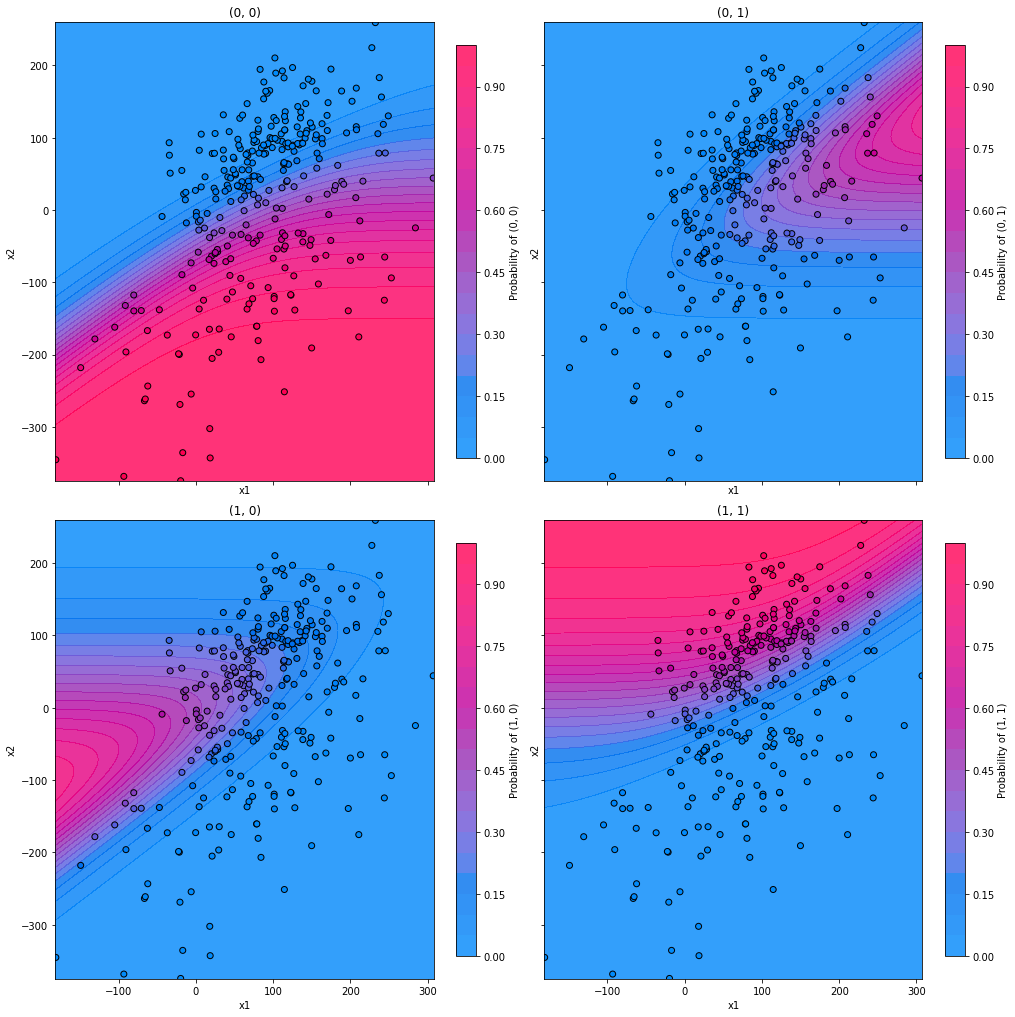

In [47]:
comparer.plot_decision_boundaries(X, kind='proba', type='mclass-diffclf')
plt.savefig('b-ignores-feature-decision-boundaries-diffclf-mclass-proba.pdf')

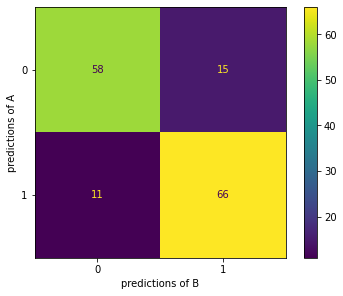

In [51]:
comparer.plot_confusion_matrix(X_train)

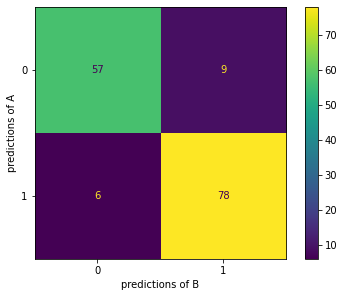

In [52]:
comparer.plot_confusion_matrix(X_explain)
plt.savefig('b-ignores-feature-cm.pdf')

# Test Set

In [59]:
X_explain_test, _ = make_blobs(n_samples=10000, centers=1, cluster_std=100, random_state=2)
X_explain_test[:, 0] += x1_where_x2_crosses
X_explain_test[:, 1] += x2_lim
y_explain_test = comparer.predict_mclass_diff(X_explain_test)
with open('test.pickle', 'wb') as f:
    pickle.dump((X_explain_test, y_explain_test), f)

In [10]:
with open('test.pickle', 'rb') as f:
    X_explain_test, y_explain_test = pickle.load(f)

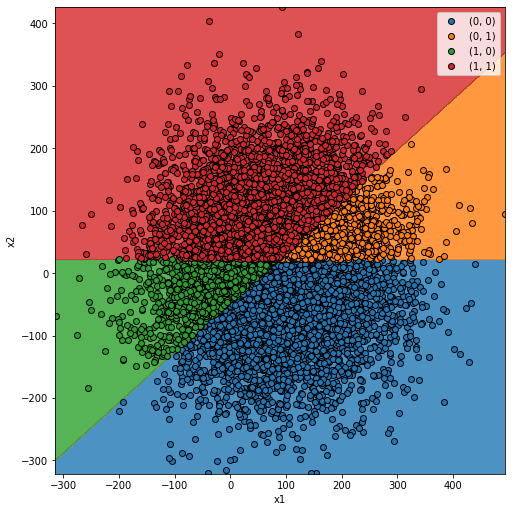

In [60]:
comparer.plot_decision_boundaries(X_explain_test)

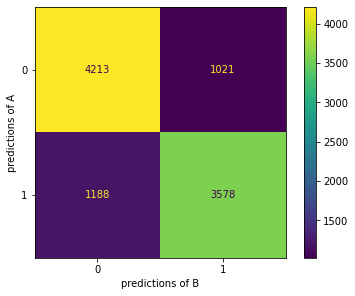

In [61]:
comparer.plot_confusion_matrix(X_explain_test)

# Additional Plots

In [5]:
from explainers import plot_feature_dependence
import shap

In [6]:
with open('indiv.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

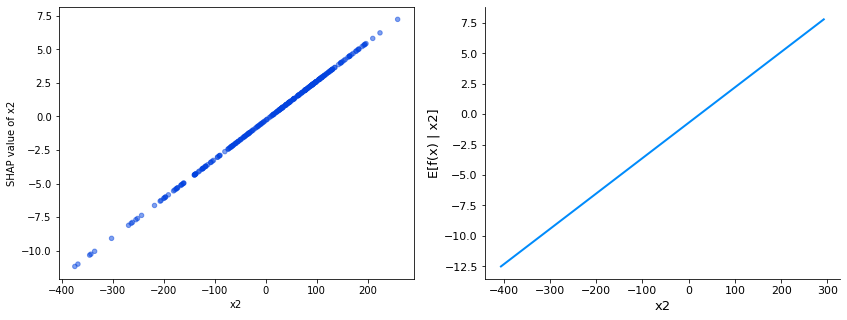

In [7]:
feature_idx, feature_name = comparer.check_feature('x2')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], feature_idx, alpha=0.5, ax=axs[0], show=False)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

In [8]:
with open('diffclf.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

In [9]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')

In [10]:
is_different = comparer.predict_bin_diff(X)

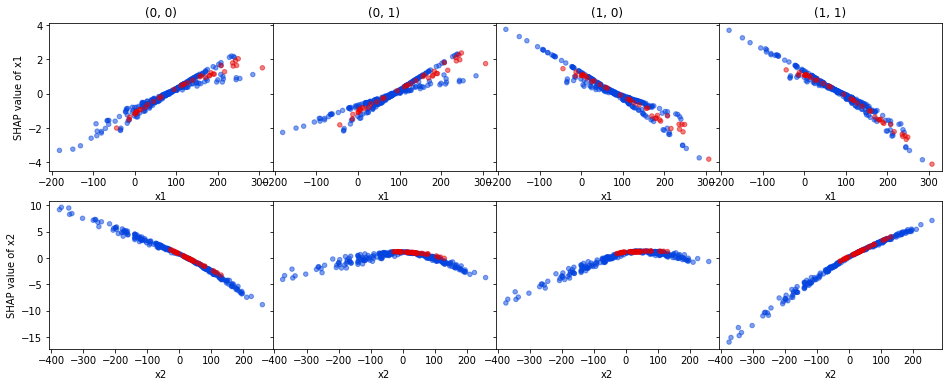

In [11]:
plot_feature_dependencies(shap_values, color=is_different, alpha=0.5, figsize=(4, 3))

In [12]:
feature_idx, feature_name = comparer.check_feature('x2')

SHAP Dependence Plot vs. PDP

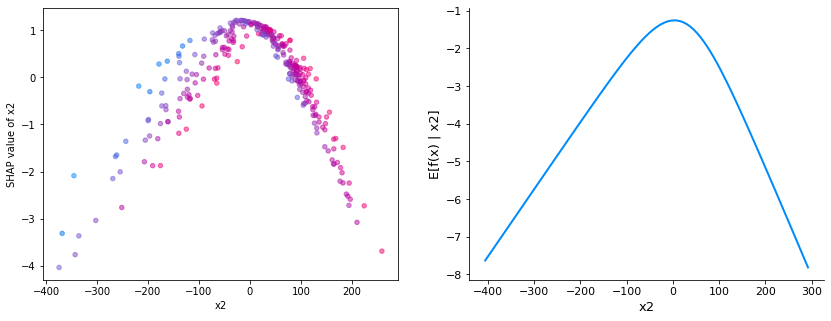

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False,
                        color=shap_values[:, 'x1', focus_class].data, color_label='x1')
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

In [14]:
from importlib import reload
import explainers
reload(explainers)
from explainers import *

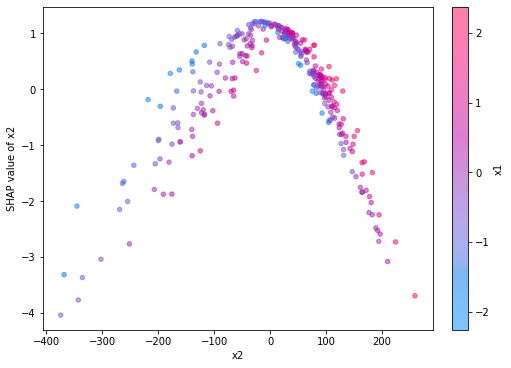

In [15]:
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5,
                        color=shap_values[:, 'x1', focus_class].values, color_label='x1')

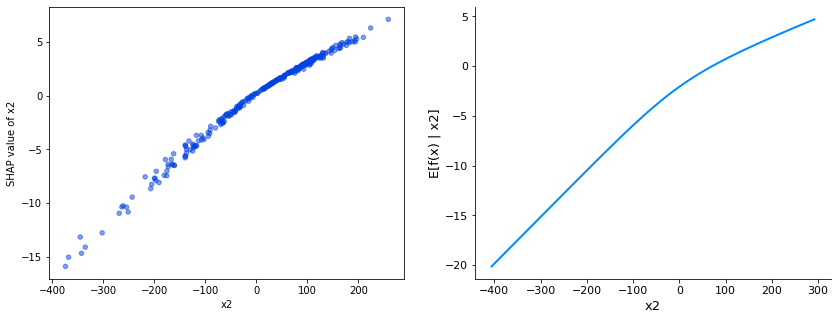

In [16]:
feature_idx, feature_name = comparer.check_feature('x2')
focus_class_idx, focus_class = comparer.check_class('(1, 1)')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

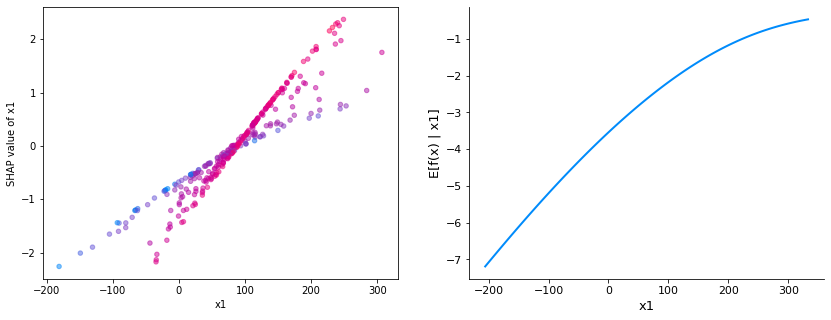

In [17]:
feature_idx, feature_name = comparer.check_feature('x1')
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0], show=False,
                        color=shap_values[:, 'x2', focus_class].data, color_label='x2')
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_mclass_diff_log_odds(X)[:, focus_class_idx],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])